# Import  python libraries

In [ ]:
#!pip install tensorflow==1.14.0

In [4]:
# Program to train the Keras ConvNet and use it for predictions


############ Import all the necessary modules #############

from __future__ import division, print_function
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Model
import numpy as np
import seaborn as sn
import scipy.signal as signal
import time
import os, sys, argparse
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import pandas as pd
#from pandas_ml import ConfusionMatrix
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import precision_score, recall_score,f1_score
#from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
#from rtlsdr import RtlSdr
import pickle
import glob


# Dataset collection

In [5]:
class DataSet2(object):

    def __init__(self, images, labels, img_names, cls):
        self._num_examples = images.shape[0]

        self._images = images
        self._labels = labels
        self._img_names = img_names
        self._cls = cls
        self._epochs_done = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._img_names

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_done(self):
        return self._epochs_done

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]

# Split the dataset into training and validation set (70:30)

In [7]:
def read_train_sets2(train_path, classes, validation_size):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images, labels, img_names, cls = load_train2(train_path, classes)  # 2 calculating, 3 loading
    images, labels, img_names, cls = shuffle(images, labels, img_names, cls)

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])

    validation_images = images[:validation_size]
    validation_labels = labels[:validation_size]
    validation_img_names = img_names[:validation_size]
    validation_cls = cls[:validation_size]

    train_images = images[validation_size:]
    train_labels = labels[validation_size:]
    train_img_names = img_names[validation_size:]
    train_cls = cls[validation_size:]
#     print('Training dataset shape:',len (train_images))
    data_sets.train = DataSet2(train_images, train_labels, train_img_names, train_cls)
    data_sets.valid = DataSet2(validation_images, validation_labels, validation_img_names, validation_cls)

    return data_sets

#  RF Samples to Image conversion 

In [8]:
def load_train2(train_path, classes):
    samples = []
    labels = []
    sample_names = []
    cls = []

    for fields in classes:
        index = classes.index(fields)
        path = os.path.join(train_path, fields, '*.npy')
        files = glob.glob(path)
        for fl in files:
            iq_samples = np.load(fl)
            real = np.real(iq_samples)
            imag = np.imag(iq_samples)

            iq_samples = np.ravel(np.column_stack((real, imag)))

            multiple = False
            if multiple:
                iq_samples1 = iq_samples[:1568]
                iq_samples1 = iq_samples1.reshape(28, 28, 2)
                iq_samples2 = iq_samples[1568:3136]
                iq_samples2 = iq_samples2.reshape(28, 28, 2)
                iq_samples3 = iq_samples[3136:4704]
                iq_samples3 = iq_samples3.reshape(28, 28, 2)
                iq_samples4 = iq_samples[4704:6272]
                iq_samples4 = iq_samples4.reshape(28, 28, 2)
                samples.append(iq_samples1)
                samples.append(iq_samples2)
                samples.append(iq_samples3)
                samples.append(iq_samples4)

                flbase = os.path.basename(fl)
                label = np.zeros(len(classes))
                label[index] = 1.0

                labels.append(label)
                labels.append(label)
                labels.append(label)
                labels.append(label)
                sample_names.append(flbase)
                sample_names.append(flbase)
                sample_names.append(flbase)
                sample_names.append(flbase)
                cls.append(fields)
                cls.append(fields)
                cls.append(fields)
                cls.append(fields)
            else:
                iq_samples = iq_samples[:1568]
                iq_samples = iq_samples.reshape(28, 28, 2)
                samples.append(iq_samples)

                label = np.zeros(len(classes))
                label[index] = 1.0
                labels.append(label)
                flbase = os.path.basename(fl)
                sample_names.append(flbase)
                cls.append(fields)

    samples = np.array(samples)
    labels = np.array(labels)
    sample_names = np.array(sample_names)
    cls = np.array(cls)
    return samples, labels, sample_names, cls

# Parameters used to read samples from SDR

In [9]:
# Function to read the samples from _prediction_samples.dat files

def read_samples_sdr(freq):
    sdr = RtlSdr()
    sdr.sample_rate = sample_rate
    sdr.err_ppm = 56   # change it to yours
    sdr.gain = 'auto'

    f_offset = 250000  # shifted tune to avoid DC
    sdr.center_freq = freq - f_offset
    time.sleep(0.06)
    iq_samples = sdr.read_samples(1221376)
    iq_samples = iq_samples[0:600000]
    fc1 = np.exp(-1.0j * 2.0 * np.pi * f_offset / sample_rate * np.arange(len(iq_samples)))  # shift down 250kHz
    iq_samples = iq_samples * fc1
    return iq_samples


def read_samples(freq):
    f_offset = 250000  # Shifted tune to avoid DC
    samp = np.fromfile(str(freq)+'_prediction_samples.dat',np.uint8)+np.int8(-127) # Adding a signed int8 to an unsigned one results in an int16 array
    x1 = samp[::2]/128 # Even samples are real(In-phase)
    x2 = samp[1::2]/128 # Odd samples are imaginary(Quadrature-phase)
    iq_samples = x1+x2*1j # Create the complex data samples
    iq_samples = iq_samples[0:600000]
    fc1 = np.exp(-1.0j * 2.0 * np.pi * f_offset / sample_rate * np.arange(len(iq_samples)))  # Shift down 250kHz
    iq_samples = iq_samples * fc1
    return iq_samples


# Data for training the model

In [10]:
########### Main Code #################################

############ Data for training the model #################
train_path ='/kaggle/input/rfsc-dataset/Dataset_Deep_Radio/Dataset_Deep_Radio/training_data'
classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))] # Gets classes from all the folders mentioned under training_data folder
print(classes)
# classes = ['BPSK','GMSK','QPSK']
num_classes = len(classes)
data = read_train_sets2(train_path, classes, validation_size=0.3) # Gets the data object using a class in dataset2.py

Xtrain = data.train.images
Ytrain = data.train.labels
Xtest = data.valid.images
Ytest = data.valid.labels

print('Training dataset shape:',Xtrain.shape)
print('Training dataset label:',Ytrain.shape)
print('Testing dataset shape:',Xtest.shape)
print('Testing dataset label:',Ytest.shape)


['OTHER', 'CPFSK', 'GFSK', '64QAM', 'BPSK', '16QAM', 'GMSK', 'QPSK']
Training dataset shape: (2100, 28, 28, 2)
Training dataset label: (2100, 8)
Testing dataset shape: (900, 28, 28, 2)
Testing dataset label: (900, 8)


# CNN Architecture

## 1. Model 1

In [68]:
######### Model 1 ######

print("Model 1") 
DIM1 = 28
DIM2 = 28
INPUT_DIM = 28*28*2
    
input_signal = Input(shape=(DIM1, DIM2, 2)) # Input tensor
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_signal) # First convolutional layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Maxpooling
x = Dropout(0.1)(x)
x = Conv2D(64,(3, 3), activation='relu', padding='same')(x) # Second convolutional layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Maxpooling
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # Third convolutional layer
x = BatchNormalization()(x) 
x = MaxPooling2D((2, 2), padding='same')(x) # Maxpooling
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # 4th convolutional layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Maxpooling
x = Flatten()(x) # Flatten the layer 
x = Dense(128, activation='relu')(x) # Dense layer
x = BatchNormalization()(x) 
#x = Dropout(0.1)(x)
x = Dense(num_classes, activation='softmax')(x) # Dense layer with SoftMax activation for output

Model 1


In [69]:
filepath = "saved-model1-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,save_best_only=True, mode='auto', period=1)
    

In [70]:
model1 = Model(inputs=input_signal, outputs=x) # Creates a model object of the Keras Model class with required input and ConvNet architecture dimesnions
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Specify the loss function type, optimiser type and metrics of the ConvNet
model1.summary()
history1 = model1.fit(Xtrain, Ytrain, epochs=50, batch_size=128, shuffle=True, validation_data=(Xtest, Ytest),callbacks=[checkpoint]) # Train the ConvNet

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 28, 28, 2)]       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 128)       2432      
_________________________________________________________________
batch_normalization_46 (Batc (None, 28, 28, 128)       512       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_47 (Batc (None, 14, 14, 64)        256 

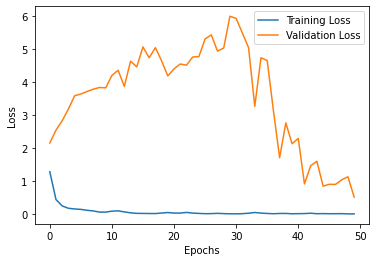

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
# Get training and validation loss from the history object
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### model1 - evaluation scores

In [72]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Assuming you have a test dataset and corresponding labels
test_images = Xtest
test_labels = Ytest

# Make predictions on the test dataset
predictions = model1.predict(test_images)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_labels, axis=1)
print(predicted_labels.shape)
print(test_labels.shape)
# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(
    test_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
confusion_matrix = confusion_matrix(test_labels, predicted_labels)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Confusion Matrix:")
print(confusion_matrix)


(900,)
(900,)
Accuracy: 0.8488888888888889
Precision: 0.8723370044811475
Recall: 0.8488888888888889
F1 Score: 0.8426887907906502
Confusion Matrix:
[[118   0   0   0   0   0   0   0]
 [  0 109   0   0   0   0   0   0]
 [  0   0  86  21   0   0   1   0]
 [  0   0   1 106   0  21   0   1]
 [  0   0   0   0 102   0   2   1]
 [  0   0   0   1   1  98   0   0]
 [  0   0  67   1   0   0  47   1]
 [  0  15   0   0   2   0   0  98]]


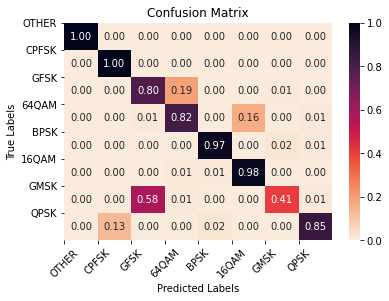

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Normalize the Confusion Matrix
row_sums = np.sum(confusion_matrix, axis=1)
# Divide each row of the confusion matrix by the corresponding row sum
normalized_confusion_matrix = confusion_matrix / row_sums[:, np.newaxis]

# Create a heatmap
sns.heatmap(normalized_confusion_matrix, annot=True, cmap="rocket_r", fmt="0.2f", cbar=True)

# Add labels, title, and axis ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=np.arange(len(classes)), labels=classes, rotation=0)

# Show the plot
plt.show()

## 2. Model 2

In [63]:
######### Model 2 ######

print("Model 2") 
DIM1 = 28
DIM2 = 28
INPUT_DIM = 28*28*2
    
input_signal = Input(shape=(DIM1, DIM2, 2)) # Input tensor
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_signal) # First convolutional layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Maxpooling
x = Conv2D(64,(3, 3), activation='relu', padding='same')(x) # Second convolutional layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Maxpooling
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # Third convolutional layer
x = BatchNormalization()(x) 
x = MaxPooling2D((2, 2), padding='same')(x) # Maxpooling
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # 4th convolutional layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Maxpooling
x = Flatten()(x) # Flatten the layer 
x = Dense(128, activation='relu')(x) # Dense layer
x = BatchNormalization()(x) 
x = Dense(64, activation='relu')(x) # Dense layer
x = BatchNormalization()(x) 
x = Dropout(0.1)(x)
x = Dense(num_classes, activation='softmax')(x) # Dense layer with SoftMax activation for output

Model 2


In [39]:
filepath = "saved-model2-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,save_best_only=True, mode='auto', period=1)
    

In [64]:
model2 = Model(inputs=input_signal, outputs=x) # Creates a model object of the Keras Model class with required input and ConvNet architecture dimesnions
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Specify the loss function type, optimiser type and metrics of the ConvNet
model2.summary()
history2 = model2.fit(Xtrain, Ytrain, epochs=50, batch_size=128, shuffle=True, validation_data=(Xtest, Ytest),callbacks=[checkpoint]) # Train the ConvNet

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 28, 28, 2)]       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 128)       2432      
_________________________________________________________________
batch_normalization_40 (Batc (None, 28, 28, 128)       512       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_41 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 7, 7, 64)          0   

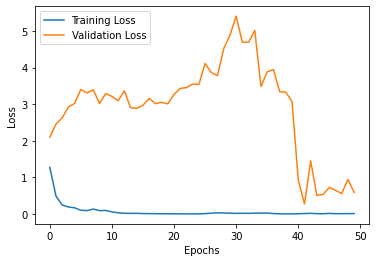

In [65]:
import matplotlib.pyplot as plt

# Get training and validation loss from the history object
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [66]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Assuming you have a test dataset and corresponding labels
test_images = Xtest
test_labels = Ytest

# Make predictions on the test dataset
predictions = model2.predict(test_images)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_labels, axis=1)
print(predicted_labels.shape)
print(test_labels.shape)
# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(
    test_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
confusion_matrix = confusion_matrix(test_labels, predicted_labels)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Confusion Matrix:")
print(confusion_matrix)


(900,)
(900,)
Accuracy: 0.8433333333333334
Precision: 0.8676045205942491
Recall: 0.8433333333333334
F1 Score: 0.830560188775691
Confusion Matrix:
[[118   0   0   0   0   0   0   0]
 [  0 109   0   0   0   0   0   0]
 [  1   0  34  66   0   0   7   0]
 [  0   0   1 104   0  22   0   2]
 [  0   0   0   0  74   0   2  29]
 [  0   0   0   0   1  98   0   1]
 [  1   1   2   2   0   0 110   0]
 [  0   2   0   1   0   0   0 112]]


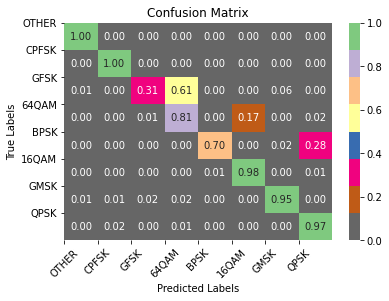

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Normalize the Confusion Matrix
row_sums = np.sum(confusion_matrix, axis=1)
# Divide each row of the confusion matrix by the corresponding row sum
normalized_confusion_matrix = confusion_matrix / row_sums[:, np.newaxis]

# Create a heatmap
sns.heatmap(normalized_confusion_matrix, annot=True, cmap="Accent_r", fmt="0.2f", cbar=True)

# Add labels, title, and axis ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=np.arange(len(classes)), labels=classes, rotation=0)

# Show the plot
plt.show()

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

## 3. Model 3

In [61]:
from tensorflow.keras.layers import Add

print("Model 3") 
DIM1 = 28
DIM2 = 28
INPUT_DIM = 28*28*2

# Input tensor
input_signal = Input(shape=(DIM1, DIM2, 2))

# First convolutional layer
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_signal)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# Second convolutional layer
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# ResNet block
residual = x
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x, residual])  # Adding the residual connection
residual = x
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x, residual])  # Adding the residual connection
residual = x
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x, residual])  # Adding the residual connection
x = MaxPooling2D((2, 2), padding='same')(x)
# Flatten the layer
x = Flatten()(x)
# Dense layers
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(num_classes, activation='softmax')(x)

Model 3


In [62]:
filepath = "saved-model3-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,save_best_only=True, mode='auto', period=1)
    

In [51]:
######### Training the model using Keras Utils ###########

model3 = Model(inputs=input_signal, outputs=x) # Creates a model object of the Keras Model class with required input and ConvNet architecture dimesnions
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Specify the loss function type, optimiser type and metrics of the ConvNet
model3.summary()
history3 = model3.fit(Xtrain, Ytrain, epochs=50, batch_size=128, shuffle=True, validation_data=(Xtest, Ytest),callbacks=[checkpoint]) # Train the ConvNet

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 2)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 28, 28, 128)  2432        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 28, 28, 128)  512         conv2d_16[0][0]                  
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 28, 28, 128)  0           batch_normalization_22[0][0]     
____________________________________________________________________________________________

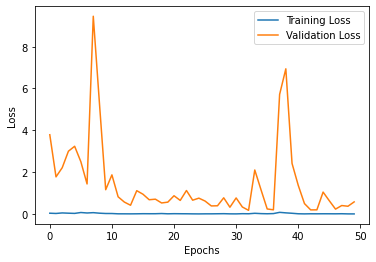

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
# Get training and validation loss from the history object
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [53]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Assuming you have a test dataset and corresponding labels
test_images = Xtest
test_labels = Ytest

# Make predictions on the test dataset
predictions = model3.predict(test_images)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_labels, axis=1)
print(predicted_labels.shape)
print(test_labels.shape)
# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(
    test_labels, predicted_labels, average='weighted')

# Calculate confusion matrix
confusion_matrix = confusion_matrix(test_labels, predicted_labels)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Confusion Matrix:")
print(confusion_matrix)


(900,)
(900,)
Accuracy: 0.8422222222222222
Precision: 0.8499924026372346
Recall: 0.8422222222222222
F1 Score: 0.840083229982314
Confusion Matrix:
[[118   0   0   0   0   0   0   0]
 [  0 109   0   0   0   0   0   0]
 [  0   1  59  48   0   0   0   0]
 [  0   0   1  93   2  32   0   1]
 [  0   0   0   0 100   0   1   4]
 [  0   0   0   1   9  90   0   0]
 [  0   0  35   2   2   0  76   1]
 [  0   1   0   0   1   0   0 113]]


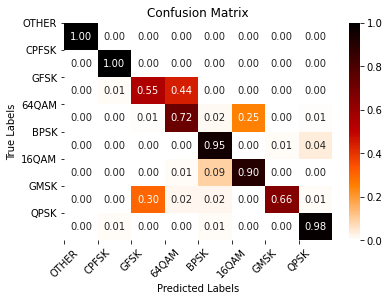

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Normalize the Confusion Matrix
row_sums = np.sum(confusion_matrix, axis=1)
# Divide each row of the confusion matrix by the corresponding row sum
normalized_confusion_matrix = confusion_matrix / row_sums[:, np.newaxis]

# Create a heatmap
sns.heatmap(normalized_confusion_matrix, annot=True, cmap="gist_heat_r", fmt="0.2f", cbar=True)

# Add labels, title, and axis ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=np.arange(len(classes)), labels=classes, rotation=0)

# Show the plot
plt.show()